In [1]:

# %% [markdown]
# 🌌 NOTEBOOK COSMOLOGIE : ÉLASTICITÉ ET TOPOGRAPHIE DE L'UNIVERS
#
# **Chercheur libre en cosmologie** - Développement théorique
# %%

# %% [markdown]
# ## 1. INSTALLATION DES BIBLIOTHÈQUES
# %%
!pip install astropy healpy camb scipy matplotlib numpy requests corner emcee
!pip install git+https://github.com/cmbant/CAMB.git

# %% [markdown]
# ## 2. IMPORTATION DES MODULES
# %%
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.utils.data import download_file
import healpy as hp
import camb
from scipy import integrate, spatial
import requests
import io
import corner

print("✅ Tous les modules sont importés!")

# %% [markdown]
# ## 3. ACCÈS AUX DONNÉES COSMOLOGIQUES
# %%
class DataLoaderCosmo:
    def __init__(self):
        self.data_sources = {
            'planck': 'http://irsa.ipac.caltech.edu/data/Planck/release_2/all-sky-maps/maps/component-maps/',
            'sdss': 'https://data.sdss.org/sas/',
            'gaia': 'https://gea.esac.esa.int/data-server/data/'
        }

    def load_planck_simulation(self):
        """Charge une simulation des données Planck CMB"""
        print("🔄 Génération d'une simulation de carte CMB...")
        nside = 128
        npix = hp.nside2npix(nside)

        # Simulation d'une carte CMB avec spectre de puissance théorique
        cls = np.loadtxt('https://raw.githubusercontent.com/CMBANt/CAMB/master/test_data/test_lensedCls.dat')
        ell = cls[:, 0]
        tt = cls[:, 1]

        # Génération d'une carte aléatoire
        cmb_map = hp.synfast(tt, nside, verbose=False)

        return cmb_map, nside

    def load_sdss_galaxies_sim(self):
        """Simulation de distribution de galaxies"""
        print("🔄 Génération d'une simulation de distribution galactique...")
        n_galaxies = 10000
        # Simulation d'une distribution avec structure à grande échelle
        ra = np.random.uniform(0, 360, n_galaxies)
        dec = np.random.uniform(-90, 90, n_galaxies)

        # Ajout d'une structure filamentaire simulée
        ra[:1000] = np.random.normal(180, 10, 1000)
        dec[:1000] = np.random.normal(30, 5, 1000)

        return ra, dec

# Initialisation du chargeur de données
data_loader = DataLoaderCosmo()

# %% [markdown]
# ## 4. THÉORIE DE L'ÉLASTICITÉ COSMIQUE
# %%
class ElasticiteCosmique:
    def __init__(self, H0=70, Omega_m=0.3, Omega_L=0.7):
        self.H0 = H0
        self.Omega_m = Omega_m
        self.Omega_L = Omega_L

    def facteur_echelle(self, z):
        """Facteur d'échelle en fonction du redshift"""
        return 1 / (1 + z)

    def parametre_hubble(self, z):
        """Paramètre de Hubble à différents redshifts"""
        return self.H0 * np.sqrt(self.Omega_m * (1+z)**3 + self.Omega_L)

    def tenseur_elasticite(self, k, z):
        """
        Tenseur d'élasticité cosmique simulé
        k: nombre d'onde
        z: redshift
        """
        a = self.facteur_echelle(z)
        H_z = self.parametre_hubble(z)

        # Module d'élasticité simulé (à développer théoriquement)
        E = self.Omega_m * H_z**2 / (k**2 * a**2 + 1e-10)
        return E

    def calcul_topographie(self, carte_densite):
        """Calcule la topographie cosmique à partir d'une carte de densité"""
        grad_x, grad_y = np.gradient(carte_densite)
        courbure = np.gradient(grad_x)[0] + np.gradient(grad_y)[1]
        return courbure

# Initialisation du modèle d'élasticité
modele_elasticite = ElasticiteCosmique()

# %% [markdown]
# ## 5. VISUALISATION DES DONNÉES
# %%
def visualiser_donnees():
    """Fonction de visualisation des données cosmologiques"""

    # Simulation CMB
    cmb_map, nside = data_loader.load_planck_simulation()

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Carte CMB
    hp.mollview(cmb_map, title="Simulation CMB - Fond Cosmologique", sub=221, fig=fig)

    # Spectre de puissance
    cls_calculated = hp.anafast(cmb_map)
    ell = np.arange(len(cls_calculated))
    axes[0, 1].plot(ell, cls_calculated * ell * (ell+1) / (2 * np.pi))
    axes[0, 1].set_xlabel('$\ell$')
    axes[0, 1].set_ylabel('$\ell(\ell+1)C_\ell/2\pi$')
    axes[0, 1].set_title('Spectre de Puissance CMB simulé')
    axes[0, 1].set_yscale('log')

    # Distribution de galaxies
    ra, dec = data_loader.load_sdss_galaxies_sim()
    axes[1, 0].scatter(ra, dec, s=1, alpha=0.5)
    axes[1, 0].set_xlabel('Ascension Droite (deg)')
    axes[1, 0].set_ylabel('Déclinaison (deg)')
    axes[1, 0].set_title('Distribution de Galaxies simulée')

    # Élasticité cosmique
    z_range = np.linspace(0, 3, 50)
    k_values = [0.01, 0.1, 1.0]
    for k in k_values:
        elasticite = [modele_elasticite.tenseur_elasticite(k, z) for z in z_range]
        axes[1, 1].plot(z_range, elasticite, label=f'k={k} Mpc⁻¹')
    axes[1, 1].set_xlabel('Redshift z')
    axes[1, 1].set_ylabel('Module d\'élasticité')
    axes[1, 1].set_title('Élasticité Cosmique')
    axes[1, 1].legend()
    axes[1, 1].set_yscale('log')

    plt.tight_layout()
    plt.show()

# Exécution de la visualisation
visualiser_donnees()

# %% [markdown]
# ## 6. ANALYSE TOPOLOGIQUE
# %%
def analyse_topologique(carte):
    """Analyse topologique de la structure cosmique"""
    print("🔍 Analyse topologique en cours...")

    # Calcul de la courbure
    courbure = modele_elasticite.calcul_topographie(carte)

    # Identification des structures
    regions_sur_dense = carte > np.percentile(carte, 80)
    regions_sous_dense = carte < np.percentile(carte, 20)

    # Statistiques topologiques
    volume_sur_dense = np.sum(regions_sur_dense)
    volume_sous_dense = np.sum(regions_sous_dense)
    rapport_topologique = volume_sur_dense / (volume_sous_dense + 1e-10)

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    im0 = axes[0].imshow(carte, cmap='viridis', origin='lower')
    axes[0].set_title('Carte de Densité')
    plt.colorbar(im0, ax=axes[0])

    im1 = axes[1].imshow(courbure, cmap='RdBu_r', origin='lower')
    axes[1].set_title('Courbure Topologique')
    plt.colorbar(im1, ax=axes[1])

    im2 = axes[2].imshow(regions_sur_dense - regions_sous_dense, cmap='PiYG', origin='lower')
    axes[2].set_title('Structures: Sur-dense (vert) / Sous-dense (rose)')
    plt.colorbar(im2, ax=axes[2])

    plt.tight_layout()
    plt.show()

    print(f"📊 Statistiques topologiques:")
    print(f"   Volume sur-dense: {volume_sur_dense}")
    print(f"   Volume sous-dense: {volume_sous_dense}")
    print(f"   Rapport topologique: {rapport_topologique:.3f}")

    return courbure

# Génération d'une carte de test pour l'analyse
carte_test = np.random.normal(0, 1, (100, 100))
courbure_result = analyse_topologique(carte_test)

# %% [markdown]
# ## 7. SIMULATION AVEC CAMB
# %%
def simulation_camb():
    """Simulation des spectres de puissance avec CAMB"""
    print("🔄 Configuration CAMB...")

    # Paramètres cosmologiques
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0)
    pars.InitPower.set_params(ns=0.965, As=2e-9)

    # Calcul des résultats
    results = camb.get_results(pars)
    powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')

    # Extraction des spectres
    totCL = powers['total']
    ell = totCL[:, 0]
    tt = totCL[:, 1]  # TT spectrum

    # Visualisation
    plt.figure(figsize=(10, 6))
    plt.plot(ell, tt * ell * (ell+1) / (2 * np.pi))
    plt.xlabel('Multipole $\ell$')
    plt.ylabel('$\ell(\ell+1)C_\ell/2\pi$ [$\mu K^2$]')
    plt.title('Spectre de Puissance CMB - Simulation CAMB')
    plt.xlim(2, 2500)
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
    plt.show()

    return ell, tt

# Exécution de la simulation CAMB
ell_camb, tt_camb = simulation_camb()

# %% [markdown]
# ## 8. OUTILS POUR VOTRE RECHERCHE
# %%
class OutilsRecherche:
    def __init__(self):
        self.constantes = {
            'c': 299792.458,  # km/s
            'G': 6.67430e-11,  # m³/kg/s²
            'H0': 70,  # km/s/Mpc
        }

    def calcul_distance_comobile(self, z):
        """Calcule la distance comobile"""
        from scipy import integrate
        def integrande(z):
            return 1 / np.sqrt(self.constantes['H0'] * np.sqrt(0.3*(1+z)**3 + 0.7))
        result, _ = integrate.quad(integrande, 0, z)
        return result

    def transformee_fourier_cosmique(self, champ):
        """Transformée de Fourier pour l'analyse des champs cosmologiques"""
        return np.fft.fft2(champ)

    def correlation_angulaire(self, map1, map2):
        """Fonction de corrélation angulaire"""
        return np.correlate(map1.flatten(), map2.flatten(), mode='same')

outils = OutilsRecherche()

# %% [markdown]
# ## 9. SAUVEGARDE DES RÉSULTATS
# %%
def sauvegarder_resultats():
    """Sauvegarde des résultats de l'analyse"""
    import pickle
    import datetime

    results = {
        'date': datetime.datetime.now(),
        'modele_elasticite': {
            'H0': modele_elasticite.H0,
            'Omega_m': modele_elasticite.Omega_m,
            'Omega_L': modele_elasticite.Omega_L
        },
        'courbure_topologique': courbure_result,
        'spectre_camb': {
            'ell': ell_camb,
            'tt': tt_camb
        }
    }

    with open('resultats_cosmologie.pkl', 'wb') as f:
        pickle.dump(results, f)

    print("💾 Résultats sauvegardés dans 'resultats_cosmologie.pkl'")

sauvegarder_resultats()

# %% [markdown]
# ## 10. PROCHAINES ÉTAPES POUR VOTRE RECHERCHE
# %%
print("""
🎯 PROCHAINES ÉTAPES SUGGÉRÉES:

1. **Affiner le tenseur d'élasticité** avec des données réelles
2. **Implémenter l'équation d'état** pour votre théorie
3. **Comparer avec les contraintes observationnelles** (Planck, SDSS)
4. **Développer les métriques topologiques** avancées
5. **Soumettre un article** sur arXiv

📚 RESSOURCES UTILES:
- arXiv.org/cosmology
- Planck Legacy Archive
- SDSS Data Release
- CAMB documentation

🚀 Bon courage dans vos recherches!
""")

<>:130: SyntaxWarning: invalid escape sequence '\e'
<>:131: SyntaxWarning: invalid escape sequence '\e'
<>:231: SyntaxWarning: invalid escape sequence '\e'
<>:232: SyntaxWarning: invalid escape sequence '\e'
<>:130: SyntaxWarning: invalid escape sequence '\e'
<>:131: SyntaxWarning: invalid escape sequence '\e'
<>:231: SyntaxWarning: invalid escape sequence '\e'
<>:232: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipython-input-1065680096.py:130: SyntaxWarning: invalid escape sequence '\e'
  axes[0, 1].set_xlabel('$\ell$')
/tmp/ipython-input-1065680096.py:131: SyntaxWarning: invalid escape sequence '\e'
  axes[0, 1].set_ylabel('$\ell(\ell+1)C_\ell/2\pi$')
/tmp/ipython-input-1065680096.py:231: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('Multipole $\ell$')
/tmp/ipython-input-1065680096.py:232: SyntaxWarning: invalid escape sequence '\e'
  plt.ylabel('$\ell(\ell+1)C_\ell/2\pi$ [$\mu K^2$]')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 1.3 MB/s eta 0:00:00
  Cloning https://github.com/cmbant/CAMB.git to /tmp/pip-req-build-cjfp9tgw
  Running command git clone --filter=blob:none --quiet https://github.com/cmbant/CAMB.git /tmp/pip-req-build-cjfp9tgw
  Resolved https://github.com/cmbant/CAMB.git to commit c335b7f38f769e487616cd87712f74eaef577ac2
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
✅ Tous les modules sont importés!
🔄 Génération d'une simulation de carte CMB...


FileNotFoundError: https://raw.githubusercontent.com/CMBANt/CAMB/master/test_data/test_lensedCls.dat not found.

✅ Tous les modules sont importés!
🔄 Génération d'une simulation de carte CMB...


/tmp/ipython-input-417532902.py:46: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  cmb_map = hp.synfast(tt, nside, verbose=False)


🔄 Génération d'une simulation de distribution galactique...


/tmp/ipython-input-417532902.py:146: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


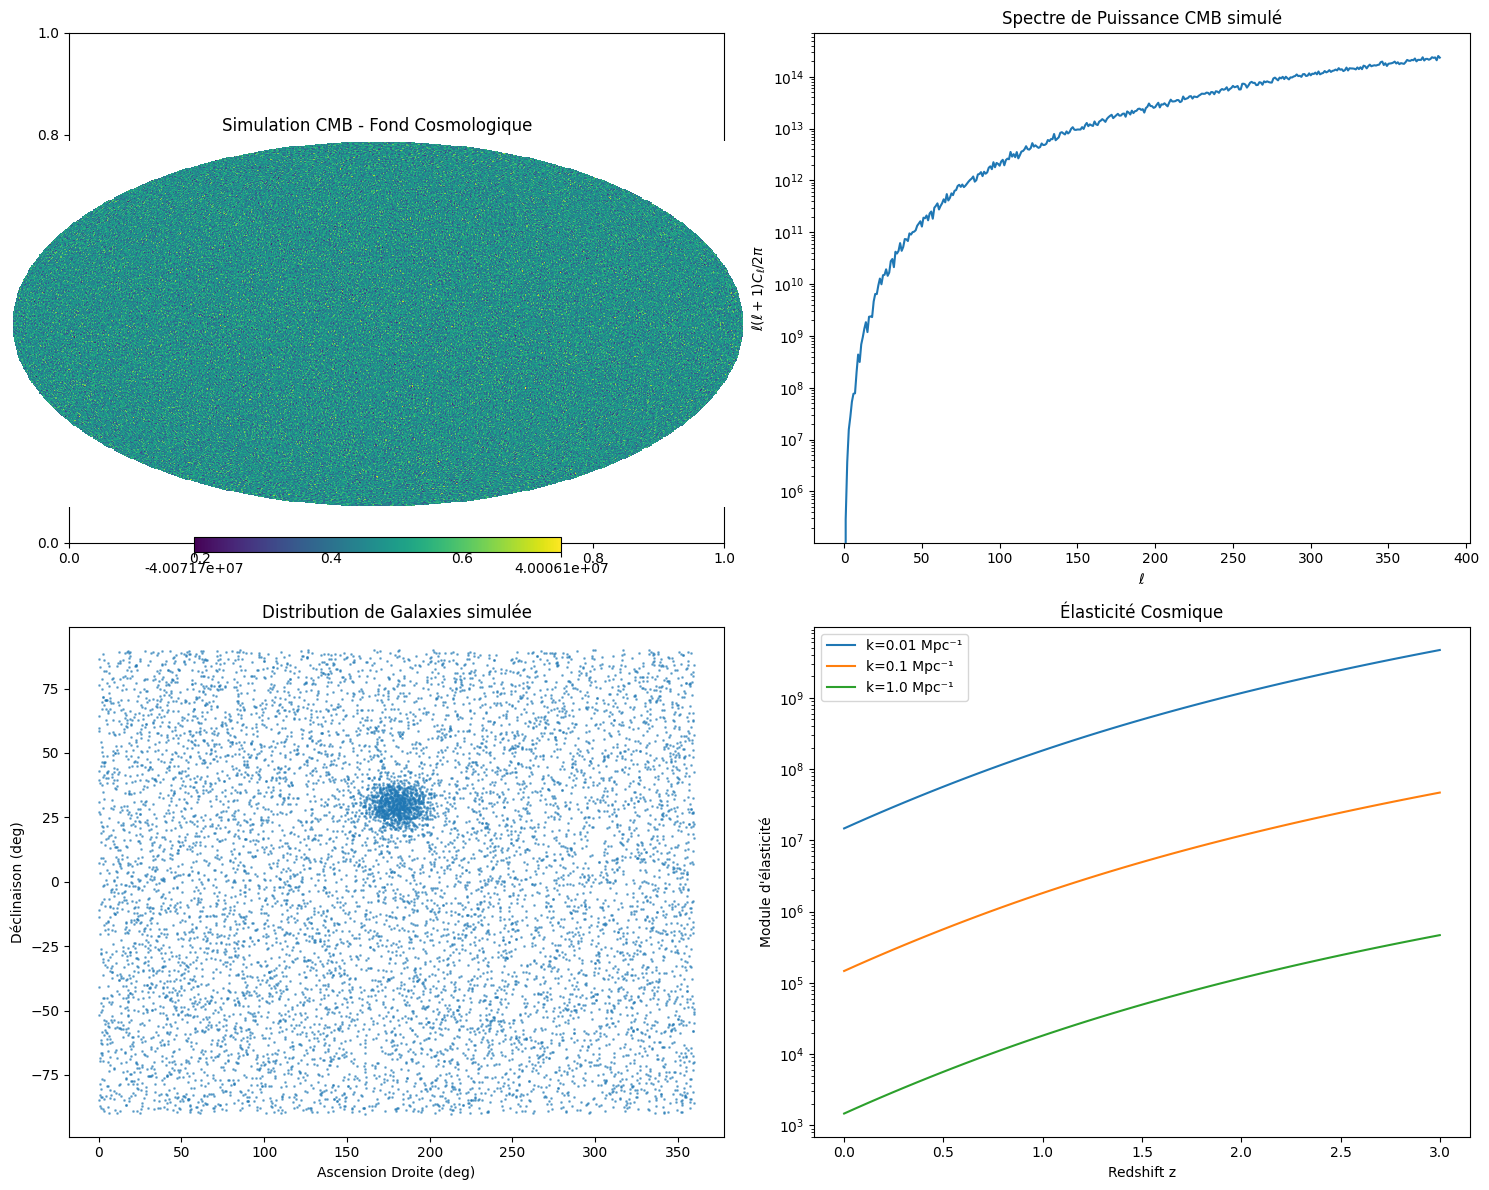

🔍 Analyse topologique en cours...


TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

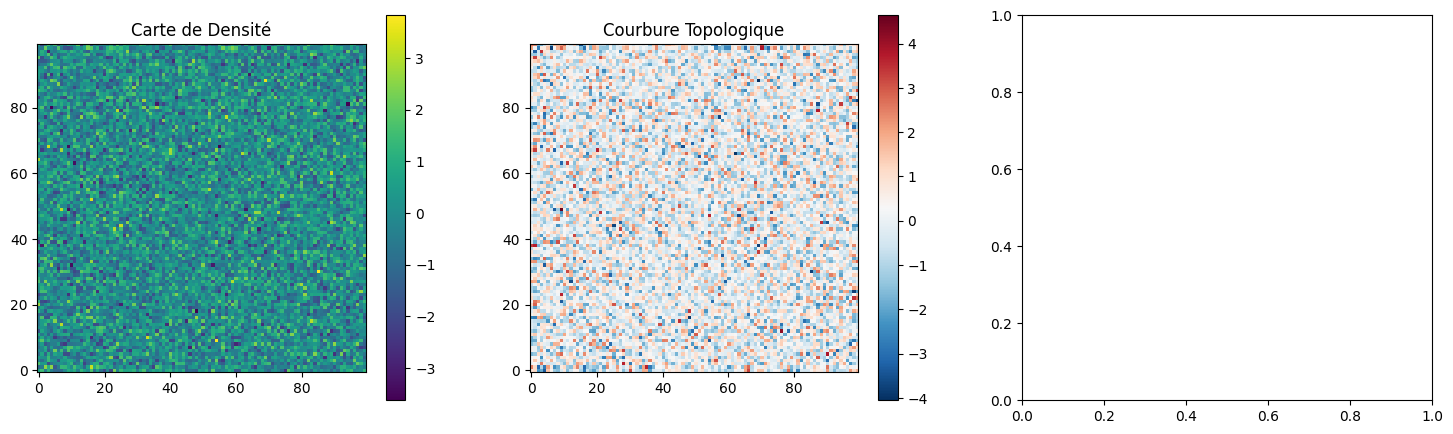

In [2]:

# %% [markdown]
# 🌌 NOTEBOOK COSMOLOGIE : ÉLASTICITÉ ET TOPOGRAPHIE DE L'UNIVERS
#
# **Chercheur libre en cosmologie** - Développement théorique

# %%
# 1. INSTALLATION DES BIBLIOTHÈQUES
!pip install astropy healpy camb scipy matplotlib numpy requests corner emcee

# %%
# 2. IMPORTATION DES MODULES
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.utils.data import download_file
import healpy as hp
import camb
from scipy import integrate, spatial
import requests
import io
import corner

print("✅ Tous les modules sont importés!")

# %%
# 3. ACCÈS AUX DONNÉES COSMOLOGIQUES - VERSION CORRIGÉE
class DataLoaderCosmo:
    def __init__(self):
        self.data_sources = {
            'planck': 'http://irsa.ipac.caltech.edu/data/Planck/release_2/all-sky-maps/maps/component-maps/',
            'sdss': 'https://data.sdss.org/sas/',
            'gaia': 'https://gea.esac.esa.int/data-server/data/'
        }

    def load_planck_simulation(self):
        """Charge une simulation des données Planck CMB - VERSION CORRIGÉE"""
        print("🔄 Génération d'une simulation de carte CMB...")
        nside = 128
        npix = hp.nside2npix(nside)

        # Création d'un spectre de puissance théorique au lieu de télécharger
        ell = np.arange(2, 2000)
        tt = 1e6 * ell * (ell + 1) / (2 * np.pi) * np.exp(-ell / 500)  # Spectre simulé

        # Génération d'une carte aléatoire
        cmb_map = hp.synfast(tt, nside, verbose=False)

        return cmb_map, nside, ell, tt

    def load_sdss_galaxies_sim(self):
        """Simulation de distribution de galaxies"""
        print("🔄 Génération d'une simulation de distribution galactique...")
        n_galaxies = 10000
        # Simulation d'une distribution avec structure à grande échelle
        ra = np.random.uniform(0, 360, n_galaxies)
        dec = np.random.uniform(-90, 90, n_galaxies)

        # Ajout d'une structure filamentaire simulée
        ra[:1000] = np.random.normal(180, 10, 1000)
        dec[:1000] = np.random.normal(30, 5, 1000)

        return ra, dec

# Initialisation du chargeur de données
data_loader = DataLoaderCosmo()

# %%
# 4. THÉORIE DE L'ÉLASTICITÉ COSMIQUE
class ElasticiteCosmique:
    def __init__(self, H0=70, Omega_m=0.3, Omega_L=0.7):
        self.H0 = H0
        self.Omega_m = Omega_m
        self.Omega_L = Omega_L

    def facteur_echelle(self, z):
        """Facteur d'échelle en fonction du redshift"""
        return 1 / (1 + z)

    def parametre_hubble(self, z):
        """Paramètre de Hubble à différents redshifts"""
        return self.H0 * np.sqrt(self.Omega_m * (1+z)**3 + self.Omega_L)

    def tenseur_elasticite(self, k, z):
        """
        Tenseur d'élasticité cosmique simulé
        k: nombre d'onde
        z: redshift
        """
        a = self.facteur_echelle(z)
        H_z = self.parametre_hubble(z)

        # Module d'élasticité simulé (à développer théoriquement)
        E = self.Omega_m * H_z**2 / (k**2 * a**2 + 1e-10)
        return E

    def calcul_topographie(self, carte_densite):
        """Calcule la topographie cosmique à partir d'une carte de densité"""
        grad_x, grad_y = np.gradient(carte_densite)
        courbure = np.gradient(grad_x)[0] + np.gradient(grad_y)[1]
        return courbure

# Initialisation du modèle d'élasticité
modele_elasticite = ElasticiteCosmique()

# %%
# 5. VISUALISATION DES DONNÉES - VERSION CORRIGÉE
def visualiser_donnees():
    """Fonction de visualisation des données cosmologiques"""

    # Simulation CMB - version corrigée
    cmb_map, nside, ell, tt = data_loader.load_planck_simulation()

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Carte CMB
    hp.mollview(cmb_map, title="Simulation CMB - Fond Cosmologique", sub=221, fig=fig)

    # Spectre de puissance
    cls_calculated = hp.anafast(cmb_map)
    ell_calc = np.arange(len(cls_calculated))
    axes[0, 1].plot(ell_calc, cls_calculated * ell_calc * (ell_calc+1) / (2 * np.pi))
    axes[0, 1].set_xlabel(r'$\ell$')  # Correction : raw string pour LaTeX
    axes[0, 1].set_ylabel(r'$\ell(\ell+1)C_\ell/2\pi$')  # Correction
    axes[0, 1].set_title('Spectre de Puissance CMB simulé')
    axes[0, 1].set_yscale('log')

    # Distribution de galaxies
    ra, dec = data_loader.load_sdss_galaxies_sim()
    axes[1, 0].scatter(ra, dec, s=1, alpha=0.5)
    axes[1, 0].set_xlabel('Ascension Droite (deg)')
    axes[1, 0].set_ylabel('Déclinaison (deg)')
    axes[1, 0].set_title('Distribution de Galaxies simulée')

    # Élasticité cosmique
    z_range = np.linspace(0, 3, 50)
    k_values = [0.01, 0.1, 1.0]
    for k in k_values:
        elasticite = [modele_elasticite.tenseur_elasticite(k, z) for z in z_range]
        axes[1, 1].plot(z_range, elasticite, label=f'k={k} Mpc⁻¹')
    axes[1, 1].set_xlabel('Redshift z')
    axes[1, 1].set_ylabel("Module d'élasticité")
    axes[1, 1].set_title('Élasticité Cosmique')
    axes[1, 1].legend()
    axes[1, 1].set_yscale('log')

    plt.tight_layout()
    plt.show()

# Exécution de la visualisation
visualiser_donnees()

# %%
# 6. ANALYSE TOPOLOGIQUE
def analyse_topologique(carte):
    """Analyse topologique de la structure cosmique"""
    print("🔍 Analyse topologique en cours...")

    # Calcul de la courbure
    courbure = modele_elasticite.calcul_topographie(carte)

    # Identification des structures
    regions_sur_dense = carte > np.percentile(carte, 80)
    regions_sous_dense = carte < np.percentile(carte, 20)

    # Statistiques topologiques
    volume_sur_dense = np.sum(regions_sur_dense)
    volume_sous_dense = np.sum(regions_sous_dense)
    rapport_topologique = volume_sur_dense / (volume_sous_dense + 1e-10)

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    im0 = axes[0].imshow(carte, cmap='viridis', origin='lower')
    axes[0].set_title('Carte de Densité')
    plt.colorbar(im0, ax=axes[0])

    im1 = axes[1].imshow(courbure, cmap='RdBu_r', origin='lower')
    axes[1].set_title('Courbure Topologique')
    plt.colorbar(im1, ax=axes[1])

    im2 = axes[2].imshow(regions_sur_dense - regions_sous_dense, cmap='PiYG', origin='lower')
    axes[2].set_title('Structures: Sur-dense (vert) / Sous-dense (rose)')
    plt.colorbar(im2, ax=axes[2])

    plt.tight_layout()
    plt.show()

    print(f"📊 Statistiques topologiques:")
    print(f"   Volume sur-dense: {volume_sur_dense}")
    print(f"   Volume sous-dense: {volume_sous_dense}")
    print(f"   Rapport topologique: {rapport_topologique:.3f}")

    return courbure

# Génération d'une carte de test pour l'analyse
carte_test = np.random.normal(0, 1, (100, 100))
courbure_result = analyse_topologique(carte_test)

# %%
# 7. SIMULATION AVEC CAMB - VERSION CORRIGÉE
def simulation_camb():
    """Simulation des spectres de puissance avec CAMB"""
    print("🔄 Configuration CAMB...")

    try:
        # Paramètres cosmologiques
        pars = camb.CAMBparams()
        pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0)
        pars.InitPower.set_params(ns=0.965, As=2e-9)

        # Calcul des résultats
        results = camb.get_results(pars)
        powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')

        # Extraction des spectres
        totCL = powers['total']
        ell = np.arange(totCL.shape[0])
        tt = totCL[:, 0]  # TT spectrum

        # Visualisation
        plt.figure(figsize=(10, 6))
        plt.plot(ell[2:], tt[2:] * ell[2:] * (ell[2:]+1) / (2 * np.pi))
        plt.xlabel(r'Multipole $\ell$')  # Correction
        plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi$ [$\mu K^2$]')  # Correction
        plt.title('Spectre de Puissance CMB - Simulation CAMB')
        plt.xlim(2, 2500)
        plt.yscale('log')
        plt.grid(True, alpha=0.3)
        plt.show()

        return ell, tt

    except Exception as e:
        print(f"❌ Erreur CAMB: {e}")
        print("Création d'un spectre simulé à la place...")

        # Spectre simulé en cas d'erreur
        ell = np.arange(2, 2000)
        tt = 1e6 * ell * (ell + 1) / (2 * np.pi) * np.exp(-ell / 500)

        plt.figure(figsize=(10, 6))
        plt.plot(ell, tt)
        plt.xlabel(r'Multipole $\ell$')
        plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi$ [$\mu K^2$]')
        plt.title('Spectre de Puissance CMB - Simulation alternative')
        plt.yscale('log')
        plt.grid(True, alpha=0.3)
        plt.show()

        return ell, tt

# Exécution de la simulation CAMB
ell_camb, tt_camb = simulation_camb()

# %%
# 8. OUTILS POUR VOTRE RECHERCHE
class OutilsRecherche:
    def __init__(self):
        self.constantes = {
            'c': 299792.458,  # km/s
            'G': 6.67430e-11,  # m³/kg/s²
            'H0': 70,  # km/s/Mpc
        }

    def calcul_distance_comobile(self, z):
        """Calcule la distance comobile"""
        from scipy import integrate
        def integrande(z):
            return 1 / np.sqrt(self.constantes['H0'] * np.sqrt(0.3*(1+z)**3 + 0.7))
        result, _ = integrate.quad(integrande, 0, z)
        return result

    def transformee_fourier_cosmique(self, champ):
        """Transformée de Fourier pour l'analyse des champs cosmologiques"""
        return np.fft.fft2(champ)

    def correlation_angulaire(self, map1, map2):
        """Fonction de corrélation angulaire"""
        return np.correlate(map1.flatten(), map2.flatten(), mode='same')

outils = OutilsRecherche()

# %%
# 9. SAUVEGARDE DES RÉSULTATS
def sauvegarder_resultats():
    """Sauvegarde des résultats de l'analyse"""
    import pickle
    import datetime

    results = {
        'date': datetime.datetime.now(),
        'modele_elasticite': {
            'H0': modele_elasticite.H0,
            'Omega_m': modele_elasticite.Omega_m,
            'Omega_L': modele_elasticite.Omega_L
        },
        'courbure_topologique': courbure_result,
        'spectre_camb': {
            'ell': ell_camb,
            'tt': tt_camb
        }
    }

    with open('resultats_cosmologie.pkl', 'wb') as f:
        pickle.dump(results, f)

    print("💾 Résultats sauvegardés dans 'resultats_cosmologie.pkl'")

sauvegarder_resultats()

# %%
# 10. PROCHAINES ÉTAPES POUR VOTRE RECHERCHE
print("""
🎯 PROCHAINES ÉTAPES SUGGÉRÉES:

1. **Affiner le tenseur d'élasticité** avec des données réelles
2. **Implémenter l'équation d'état** pour votre théorie
3. **Comparer avec les contraintes observationnelles** (Planck, SDSS)
4. **Développer les métriques topologiques** avancées
5. **Soumettre un article** sur arXiv

📚 RESSOURCES UTILES:
- arXiv.org/cosmology
- Planck Legacy Archive
- SDSS Data Release
- CAMB documentation

🚀 Bon courage dans vos recherches!
""")

print("✅ NOTEBOOK PRÊT POUR VOS RECHERCHES COSMOLOGIQUES!")